<a href="https://colab.research.google.com/github/chayaphon/DADS7202_DL/blob/main/CNN_Sushi/Xception_FineTune.ipynb\" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# List all NVIDIA GPUs as avaialble.
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3060 (UUID: GPU-299b49ee-76ac-3399-1e47-b9f202a90b71)


In [2]:
import sys
import numpy as np
import sklearn
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from IPython.display import Image, display
import matplotlib.cm as cmp
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
print( f"Python {sys.version}\n" )
print( f"NumPy {np.__version__}\n" )
%matplotlib inline
print(f'The scikit-learn version is {sklearn.__version__}')
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

Python 3.9.18 (main, Sep 11 2023, 13:30:38) [MSC v.1916 64 bit (AMD64)]

NumPy 1.26.4

The scikit-learn version is 1.5.1
TensorFlow 2.10.0
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0 , Type = GPU


# Set Seed

In [4]:
seed_value = 6952 #np.random.randint(1000, 99999)
print(seed_value)

tf.random.set_seed(seed_value)
np.random.seed(seed_value)

6952


# Prep Data

In [5]:
x1 = np.load('./Images Numpy/x_sushi_aburi_299x299.npz')
x2 = np.load('./Images Numpy/x_sushi_ebi_299x299.npz')
x3 = np.load('./Images Numpy/x_sushi_maguro_299x299.npz')
x4 = np.load('./Images Numpy/x_sushi_salmon_299x299.npz')

x1 = x1['x']
x2 = x2['x']
x3 = x3['x']
x4 = x4['x']

y1 = np.array([0 for i in range(172)])
y2 = np.array([1 for i in range(172)])
y3 = np.array([2 for i in range(172)])
y4 = np.array([3 for i in range(172)])

print(f'x1 : {x1.shape} | y1: {y1.shape}')
print(f'x2 : {x2.shape} | y2: {y2.shape}')
print(f'x3 : {x3.shape} | y3: {y3.shape}')
print(f'x4 : {x4.shape} | y4: {y4.shape}')

x1 : (172, 299, 299, 3) | y1: (172,)
x2 : (172, 299, 299, 3) | y2: (172,)
x3 : (172, 299, 299, 3) | y3: (172,)
x4 : (172, 299, 299, 3) | y4: (172,)


In [6]:
x = np.concatenate((x1, x2, x3, x4))
y = np.concatenate((y1, y2, y3, y4))
print(x.shape)
print(y.shape)

(688, 299, 299, 3)
(688,)


# Train Test Split

In [7]:
test_size = 0.2
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=seed_value, stratify=y)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(550, 299, 299, 3)
(550,)
(138, 299, 299, 3)
(138,)


# Visualize the first 10 image of x_train and x_test

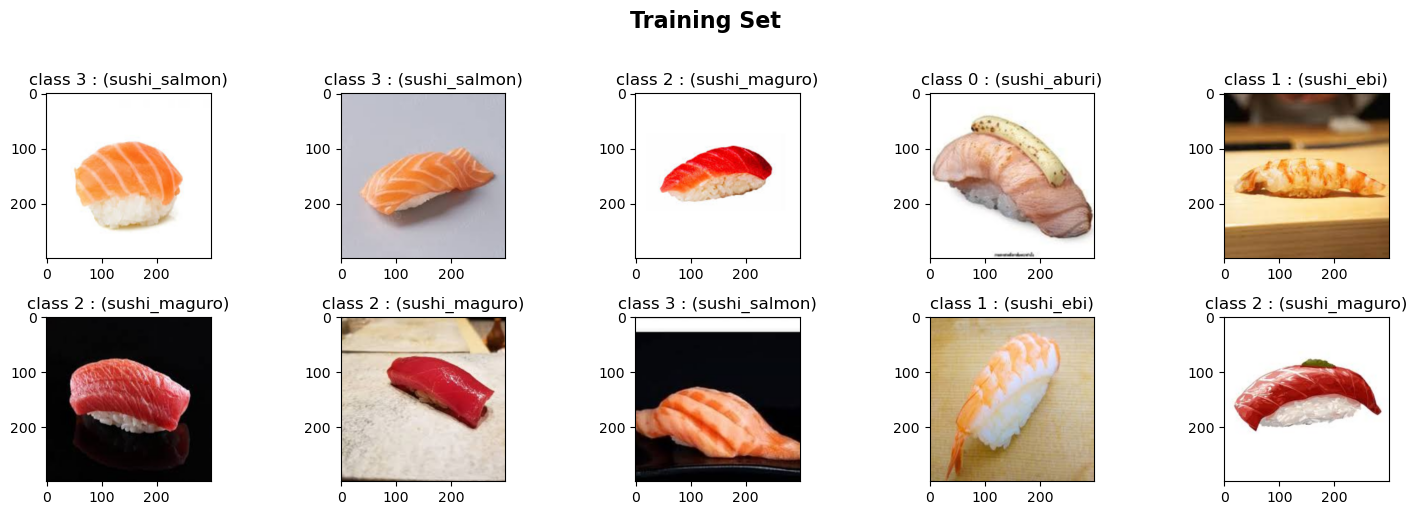

In [8]:
label = ['sushi_aburi','sushi_ebi','sushi_maguro','sushi_salmon']

plt.figure(figsize = (15,5))
plt.suptitle('Training Set', y=1.02, fontsize=16, weight='bold')
for i in range(10):
  plt.subplot(2, 5, i+1).set_title(f'class {y_train[i]} : ({label[y_train[i]]})')
  plt.imshow(x_train[i])
  
plt.tight_layout() 
plt.show()

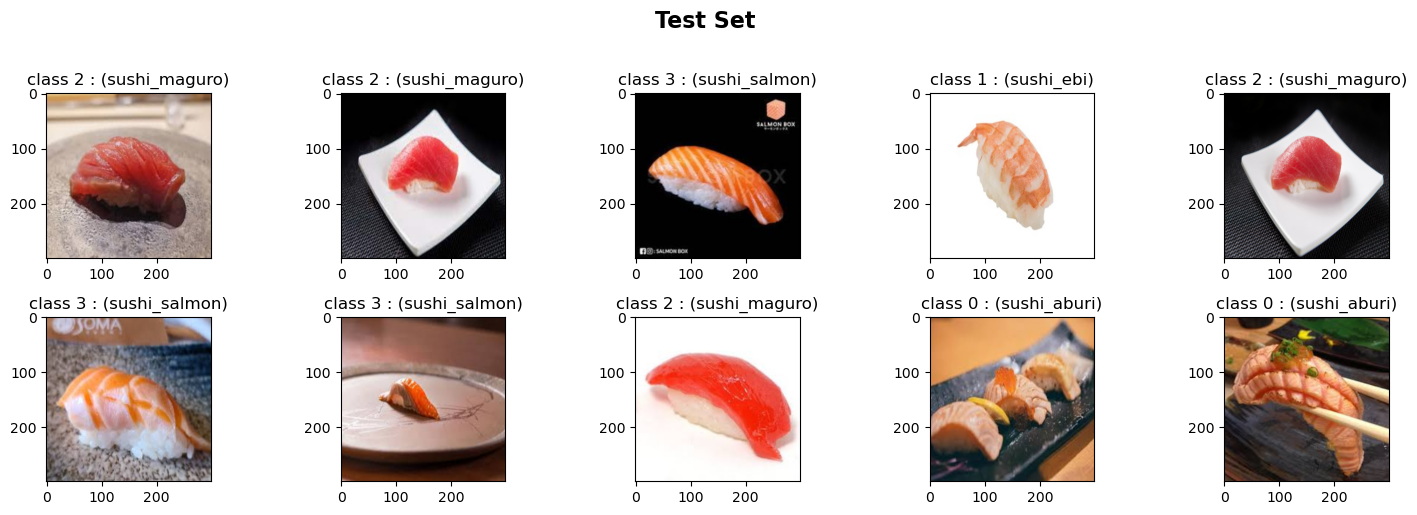

In [9]:
plt.figure(figsize = (15,5))
plt.suptitle('Test Set', y=1.02, fontsize=16, weight='bold')
for i in range(10):
  plt.subplot(2, 5, i+1).set_title(f'class {y_test[i]} : ({label[y_test[i]]})')
  plt.imshow(x_test[i])
  
plt.tight_layout()
plt.show()

# Select Pre-Trained Model Xception

In [10]:
x_extractor = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
x_extractor.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

# Prepocessing

In [11]:
x_train_xception = tf.keras.applications.xception.preprocess_input(x_train)
x_test_xception = tf.keras.applications.xception.preprocess_input(x_test)

print(x_train_xception.shape)
print(x_test_xception.shape)

(550, 299, 299, 3)
(138, 299, 299, 3)


# Data Augmentation

In [12]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    samplewise_std_normalization=True,  # Normalizes each image by its standard deviation
    rotation_range=30,                  # Rotates images by up to 30 degrees
    height_shift_range=0.2,             # Shifts images vertically by % of the total height
    width_shift_range=0.2,              # Shifts images horizontally by % of the total width
    shear_range=0.2,                    # Applies a 0.2 radian shear transformation
    zoom_range=0.2,                     # Zooms images by up to 20%
    horizontal_flip=True,               # Randomly flips images horizontally
    vertical_flip=True,                 # Randomly flips images vertically (optional)
    fill_mode='nearest',                # Fill in any missing pixels
    validation_split=0.2               # Splits 20% of the data for validation
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    samplewise_std_normalization=True,  # Normalizes each image by its standard deviation
)

# define seed to master seed
train_datagen.seed = seed_value
test_datagen.seed = seed_value

train_datagen.fit(x_train_xception)
test_datagen.fit(x_test_xception)

c:\Users\csorn\.conda\envs\DADS7202\lib\site-packages\keras\preprocessing\image.py:1471: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3904105..2.5902078].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42241317..5.4401836].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7629028..2.981854].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.3847055..5.6499825].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.8295417..0.56142277].


===== Train batch no. 1/1 =====


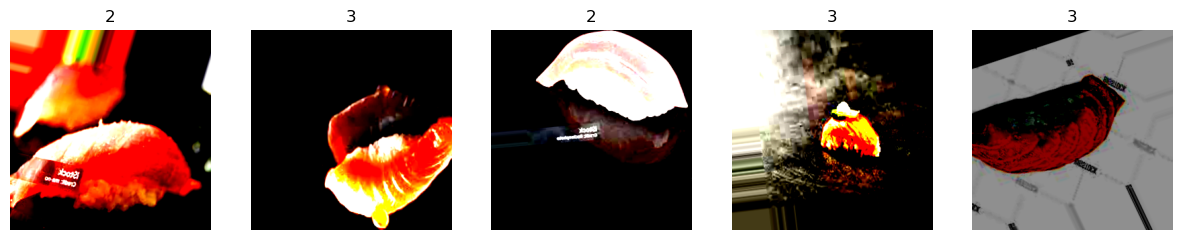

In [13]:
train_generator = train_datagen.flow(x_train, y_train, batch_size=5, subset='training')
n_show = 1   # Show 'n_show' batches of generated data (1 batch includes 5 images)
for i, (x_batch, y_batch) in enumerate(train_generator):
    print(f"===== Train batch no. {i+1}/{n_show} =====")
    plt.figure(figsize=(15, 5))
    for j in range(5):
        plt.subplot(1, 5, j+1).set_title(y_batch[j])
        plt.imshow(x_batch[j])
        plt.axis("off")  # remove all tick marks
    plt.show()

    if i+1 >= n_show:
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.4002995..0.85384566].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.5828803..0.44550905].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1774466..1.8512012].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.6511164..0.47498918].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.44539..1.7957624].


===== Validation batch no. 1/1 =====


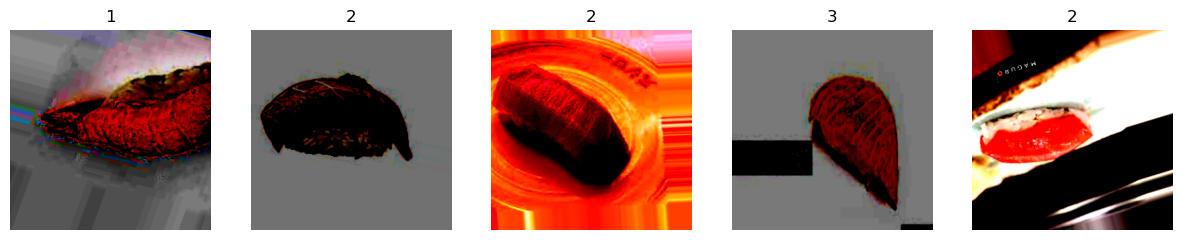

In [14]:
validation_generator = train_datagen.flow(x_train, y_train, batch_size=5, subset='validation')
n_show = 1   # Show 'n_show' batches of generated data (1 batch includes 5 images)
for i, (x_batch, y_batch) in enumerate(validation_generator):
    print(f"===== Validation batch no. {i+1}/{n_show} =====")
    plt.figure(figsize=(15, 5))
    for j in range(5):
        plt.subplot(1, 5, j+1).set_title(y_batch[j])
        plt.imshow(x_batch[j])
        plt.axis("off")  # remove all tick marks
    plt.show()

    if i+1 >= n_show:
        break

===== Test batch no. 1/1 =====

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.27561432..5.3563128].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4187568..2.9652114].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2734423..2.1925247].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2739824..3.1215682].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8329878..1.9052678].


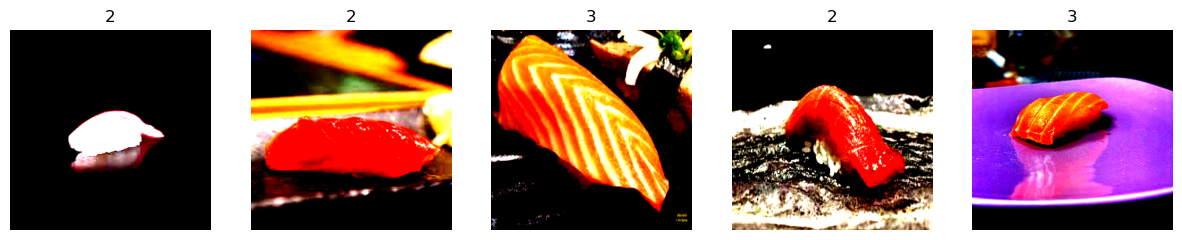

In [15]:
test_generator = test_datagen.flow(x_test, y_test, batch_size=5)
n_show = 1   # Show 'n_show' batches of generated data (1 batch includes 5 images)
for i, (x_batch, y_batch) in enumerate(test_generator):
    print(f"===== Test batch no. {i+1}/{n_show} =====")
    plt.figure(figsize=(15, 5))
    for j in range(5):
        plt.subplot(1, 5, j+1).set_title(y_batch[j])
        plt.imshow(x_batch[j])
        plt.axis("off")  # remove all tick marks
    plt.show()

    if i+1 >= n_show:
        break

# Recursively freeze all layers in the model

In [16]:
x_extractor.trainable = False
for i, layer in enumerate(x_extractor.layers):
  print(f'Layer {i}: Name = {layer.name}, Trainable = {layer.trainable}')

Layer 0: Name = input_1, Trainable = False
Layer 1: Name = block1_conv1, Trainable = False
Layer 2: Name = block1_conv1_bn, Trainable = False
Layer 3: Name = block1_conv1_act, Trainable = False
Layer 4: Name = block1_conv2, Trainable = False
Layer 5: Name = block1_conv2_bn, Trainable = False
Layer 6: Name = block1_conv2_act, Trainable = False
Layer 7: Name = block2_sepconv1, Trainable = False
Layer 8: Name = block2_sepconv1_bn, Trainable = False
Layer 9: Name = block2_sepconv2_act, Trainable = False
Layer 10: Name = block2_sepconv2, Trainable = False
Layer 11: Name = block2_sepconv2_bn, Trainable = False
Layer 12: Name = conv2d, Trainable = False
Layer 13: Name = block2_pool, Trainable = False
Layer 14: Name = batch_normalization, Trainable = False
Layer 15: Name = add, Trainable = False
Layer 16: Name = block3_sepconv1_act, Trainable = False
Layer 17: Name = block3_sepconv1, Trainable = False
Layer 18: Name = block3_sepconv1_bn, Trainable = False
Layer 19: Name = block3_sepconv2_act, 

# Un-freez some layer

In [17]:
# unfreez_layer = ['block14_sepconv2_act',]
#                 # 'block14_sepconv2_bn',
#                 # 'block14_sepconv2',
#                 # 'block14_sepconv1_act',
#                 # 'block14_sepconv1_bn',
#                 # 'block14_sepconv1',
#                 # ]

# for i, layer in enumerate(x_extractor.layers):
#     #if any(part in layer.name for part in unfreez_layer):
#     if layer.name in unfreez_layer:
#         layer.trainable = True

# for i, layer in enumerate(x_extractor.layers):
#     print(f'Layer {i}: Name = {layer.name}, Trainable = {layer.trainable}')

# Train Model

In [18]:
# tf.keras.utils.plot_model(x_extractor, to_file = './out/Xception_Model.png', show_shapes = True, show_dtype = False, show_layer_names = True, dpi = 90, expand_nested=True)

In [19]:
add_9 = x_extractor.get_layer('add_9').output
# Custom layers
custom = tf.keras.layers.Activation('relu', name='custom1_act')(add_9)
custom = tf.keras.layers.SeparableConv2D(filters=728, kernel_size=3, padding='same', name='custom1_conv2', use_bias=False)(custom)
custom = tf.keras.layers.BatchNormalization(name='custom1_bn')(custom)
custom = tf.keras.layers.Activation('relu', name='custom2_act')(custom)
custom = tf.keras.layers.SeparableConv2D(filters=728, kernel_size=3, padding='same', name='custom2_conv1', use_bias=False)(custom)
custom = tf.keras.layers.BatchNormalization(name='custom2_bn')(custom)
custom = tf.keras.layers.Activation('relu', name='custom3_act')(custom) 
custom = tf.keras.layers.SeparableConv2D(filters=728, kernel_size=3, padding='same', name='custom3_conv1', use_bias=False)(custom)
custom = tf.keras.layers.BatchNormalization(name='custom3_bn')(custom)

add_layer1 = tf.keras.layers.Add(name='add_layer1')([add_9, custom])

custom_1 = tf.keras.layers.Conv2D(filters=1024, kernel_size=3, padding='same',strides=2, name='custom11_conv2d3', use_bias=False)(add_layer1)
custom_1 = tf.keras.layers.BatchNormalization(name='custom11_bn')(custom_1)
custom = tf.keras.layers.Activation('relu', name='custom4_relu')(custom)
custom = tf.keras.layers.SeparableConv2D(filters=728, kernel_size=3, strides=2, padding='same', name='custom4_conv1', use_bias=False)(custom)
custom = tf.keras.layers.Activation('relu', name='custom5_relu')(add_layer1)
custom = tf.keras.layers.SeparableConv2D(filters=728, kernel_size=3, padding='same', name='custom5_conv1', use_bias=False)(custom)
custom = tf.keras.layers.BatchNormalization(name='custom5_bn')(custom)
custom = tf.keras.layers.Activation('relu', name='custom6_relu')(custom)
custom = tf.keras.layers.SeparableConv2D(filters=1024, kernel_size=3, padding='same', name='custom6_conv1', use_bias=False)(custom)
custom = tf.keras.layers.BatchNormalization(name='custom6_bn')(custom)
custom = tf.keras.layers.MaxPooling2D(pool_size=1, strides=2, name='custom6_max_pool')(custom)

add_layer2 = tf.keras.layers.Add(name='add_layer2')([custom, custom_1])

custom = tf.keras.layers.SeparableConv2D(filters=1536, kernel_size=3, padding='same', name='custom7_conv1', use_bias=False)(add_layer2)
custom = tf.keras.layers.BatchNormalization(name='custom7_bn')(custom)
custom = tf.keras.layers.Activation('relu', name='custom7_relu')(custom)
custom = tf.keras.layers.SeparableConv2D(filters=2048, kernel_size=3, padding='same', name='custom8_conv1', use_bias=False)(custom)
custom = tf.keras.layers.BatchNormalization(name='custom8_bn')(custom)
custom = tf.keras.layers.Activation('relu', name='custom8_relu')(custom)

block14_sepconv2_act = x_extractor.get_layer('block14_sepconv2_act').output
#add_11 = x_extractor.get_layer('add_11').output
add_layer3 = tf.keras.layers.Add(name='add_layer3')([block14_sepconv2_act, custom])

x = tf.keras.layers.GlobalAvgPool2D()(add_layer3)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
new_outputs = tf.keras.layers.Dense(4, activation='softmax', name='output_layer')(x)
model = tf.keras.models.Model(inputs=x_extractor.inputs, outputs=new_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [20]:
model.compile( optimizer=tf.keras.optimizers.Adam(learning_rate=0.001) , 
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['acc'] 
            )

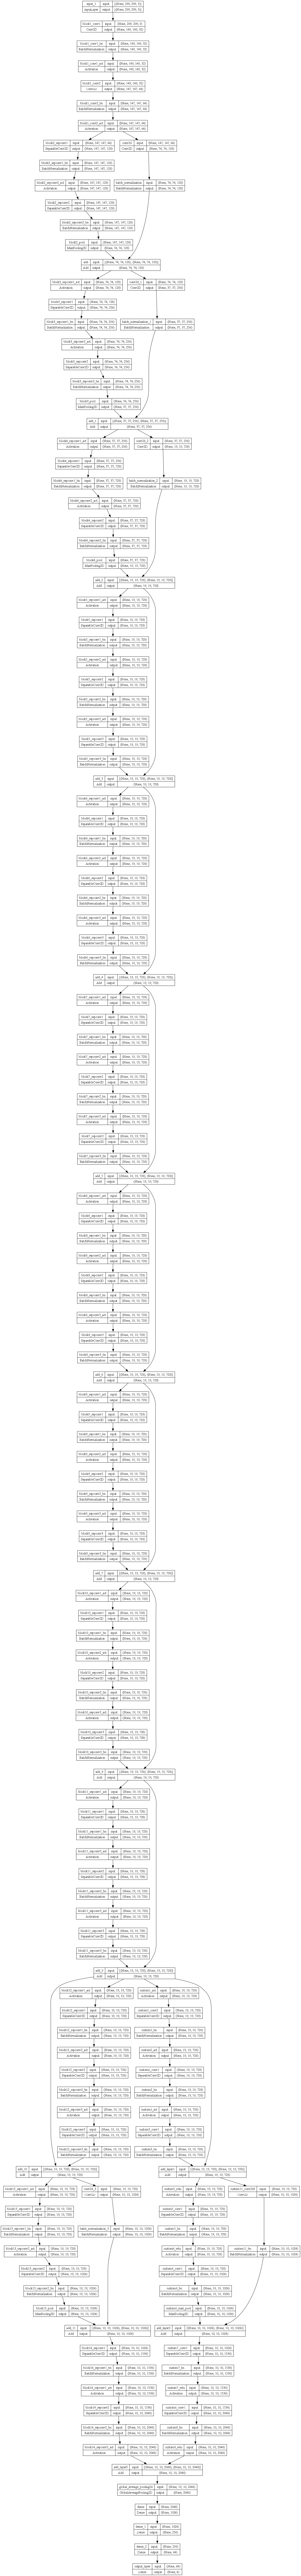

In [21]:
tf.keras.utils.plot_model(model, to_file = './out/Xception_Model.png', show_shapes = True, show_dtype = False, show_layer_names = True, dpi = 85)

# Fitting Model

In [22]:
# t_batch_size = 128
# v_batch_size = 128

# checkpoint = tf.keras.callbacks.ModelCheckpoint(
#     filepath='./save/Xception_FineTune_Model.h5',  # Path to save the model
#     monitor='val_loss',        # Monitor 'val_loss', 'val_acc', etc.
#     save_best_only=True,       # Only save when the monitored metric improves
#     mode='min'                 # 'min' means we want to minimize 'val_loss'
# )

# # Fit the model and include the checkpoint callback
# history = model.fit(
#     train_datagen.flow(x_train_xception, y_train, batch_size=t_batch_size, subset='training'),
#     epochs=100,
#     verbose=2,
#     validation_data=train_datagen.flow(x_train_xception, y_train, batch_size=v_batch_size, subset='validation'),
#     callbacks=[checkpoint]
# )

In [23]:
t_batch_size = 32
v_batch_size = 64

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    train_datagen.flow(x_train_xception, y_train, batch_size=t_batch_size, subset='training'),
    epochs=200,
    verbose=2,
    validation_data=train_datagen.flow(x_train_xception, y_train, batch_size=v_batch_size, subset='validation'),
    callbacks=[lr_schedule, early_stop]
)

Epoch 1/200
14/14 - 21s - loss: 1.3626 - acc: 0.3955 - val_loss: 1.2203 - val_acc: 0.3727 - lr: 0.0010 - 21s/epoch - 1s/step
Epoch 2/200
14/14 - 11s - loss: 1.0244 - acc: 0.5841 - val_loss: 1.2565 - val_acc: 0.3727 - lr: 0.0010 - 11s/epoch - 785ms/step
Epoch 3/200
14/14 - 8s - loss: 0.7316 - acc: 0.6932 - val_loss: 1.1690 - val_acc: 0.4182 - lr: 0.0010 - 8s/epoch - 586ms/step
Epoch 4/200
14/14 - 7s - loss: 0.4880 - acc: 0.7932 - val_loss: 1.2088 - val_acc: 0.4091 - lr: 0.0010 - 7s/epoch - 506ms/step
Epoch 5/200
14/14 - 7s - loss: 0.4362 - acc: 0.8364 - val_loss: 1.0197 - val_acc: 0.6091 - lr: 0.0010 - 7s/epoch - 512ms/step
Epoch 6/200
14/14 - 7s - loss: 0.3897 - acc: 0.8750 - val_loss: 1.0445 - val_acc: 0.6273 - lr: 0.0010 - 7s/epoch - 509ms/step
Epoch 7/200
14/14 - 7s - loss: 0.4541 - acc: 0.8227 - val_loss: 1.0311 - val_acc: 0.6364 - lr: 0.0010 - 7s/epoch - 508ms/step
Epoch 8/200

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
14/14 - 7s - loss: 0.2767 - 

In [24]:
results = model.evaluate(test_datagen.flow(x_test_xception, y_test, batch_size = 128))
print(f'{model.metrics_names}: {results}')

2/2 [==============================] - 1s 107ms/step - loss: 0.3586 - acc: 0.9130
['loss', 'acc']: [0.3586377203464508, 0.9130434989929199]


# Save Model

In [25]:
# save model
model.save('./save/Xception_FineTune_Model.h5')

# save weight
model.save_weights('./save/Xception_FineTune_Weight.h5')

# Summarize history of accuracy

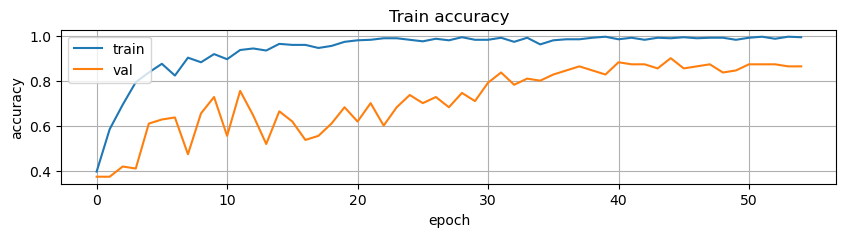

In [32]:
plt.figure(figsize = (10,2))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.grid()
plt.show()

# Summarize history for loss

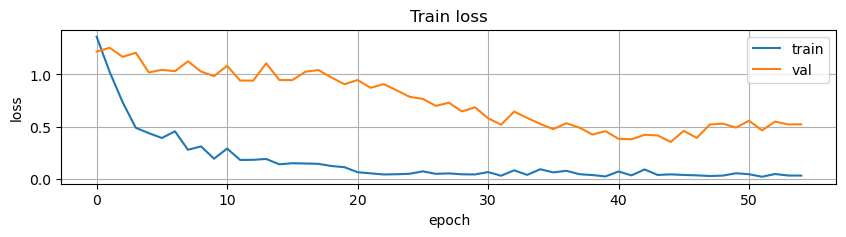

In [27]:
plt.figure(figsize = (10,2))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper right')
plt.grid()
plt.show()

# Evaluate Model

1/1 [==============================] - 0s 14ms/step


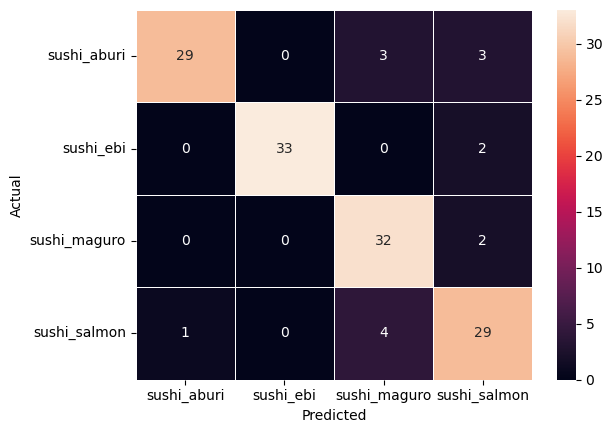

              precision    recall  f1-score   support

 sushi_aburi       0.97      0.83      0.89        35
   sushi_ebi       1.00      0.94      0.97        35
sushi_maguro       0.82      0.94      0.88        34
sushi_salmon       0.81      0.85      0.83        34

    accuracy                           0.89       138
   macro avg       0.90      0.89      0.89       138
weighted avg       0.90      0.89      0.89       138



In [28]:
# Get predictions for x_test_vgg16
y_pred = []
for i in range(len(x_test_xception)):
    x_input = x_test_xception[i][np.newaxis, ...]
    y_pred.append(np.argmax(model.predict(x_input)))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='g', xticklabels=label, yticklabels=label, linewidths=.5)
ax.set(xlabel='Predicted', ylabel='Actual')
plt.show()

# Classification Report
report = classification_report(y_test, y_pred, target_names=label)
print(report)

# Test Prediction

1/1 [==============================] - 0s 17ms/step


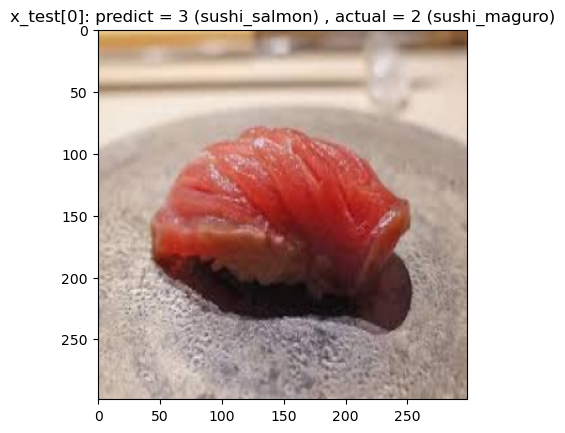

1/1 [==============================] - 0s 14ms/step


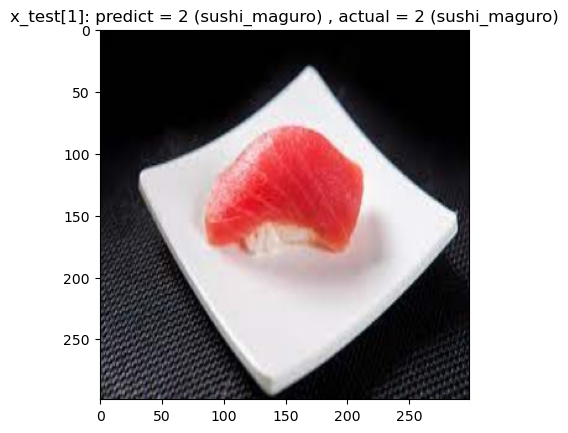

1/1 [==============================] - 0s 15ms/step


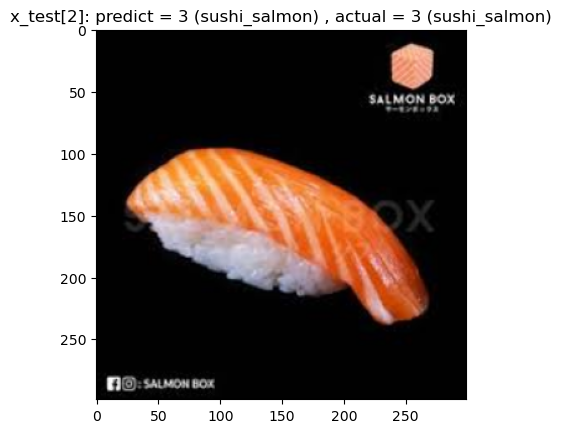

1/1 [==============================] - 0s 16ms/step


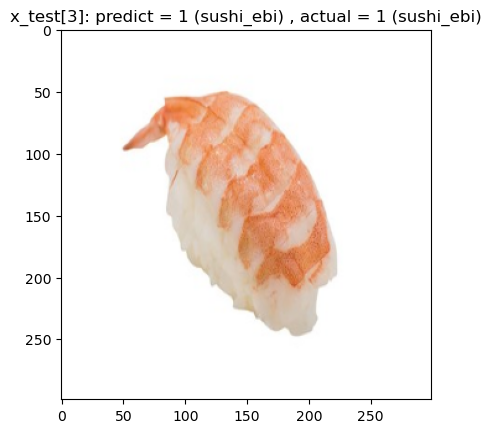

1/1 [==============================] - 0s 19ms/step


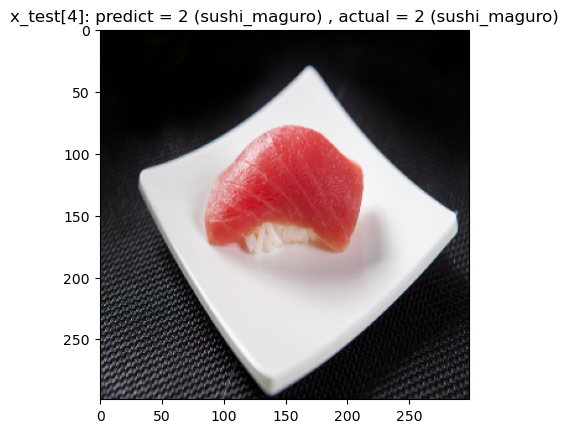

In [29]:
for i in range(5):
  y_pred = model.predict(x_test_xception[i].reshape(1,299,299,3))
  plt.imshow(x_test[i])
  plt.title(f'x_test[{i}]: predict = {np.argmax(y_pred)} ({label[np.argmax(y_pred)]}) , actual = {y_test[i]} ({label[int(y_test[i])]})')
  plt.show()

# Grad-CAM

In [30]:
img_shape = (-1, 299, 299, 3)
preprocess_input = tf.keras.applications.xception.preprocess_input
last_conv_layer_name = "add_layer3"

1/1 [==============================] - 0s 16ms/step
correct : 28, incorrect : 2


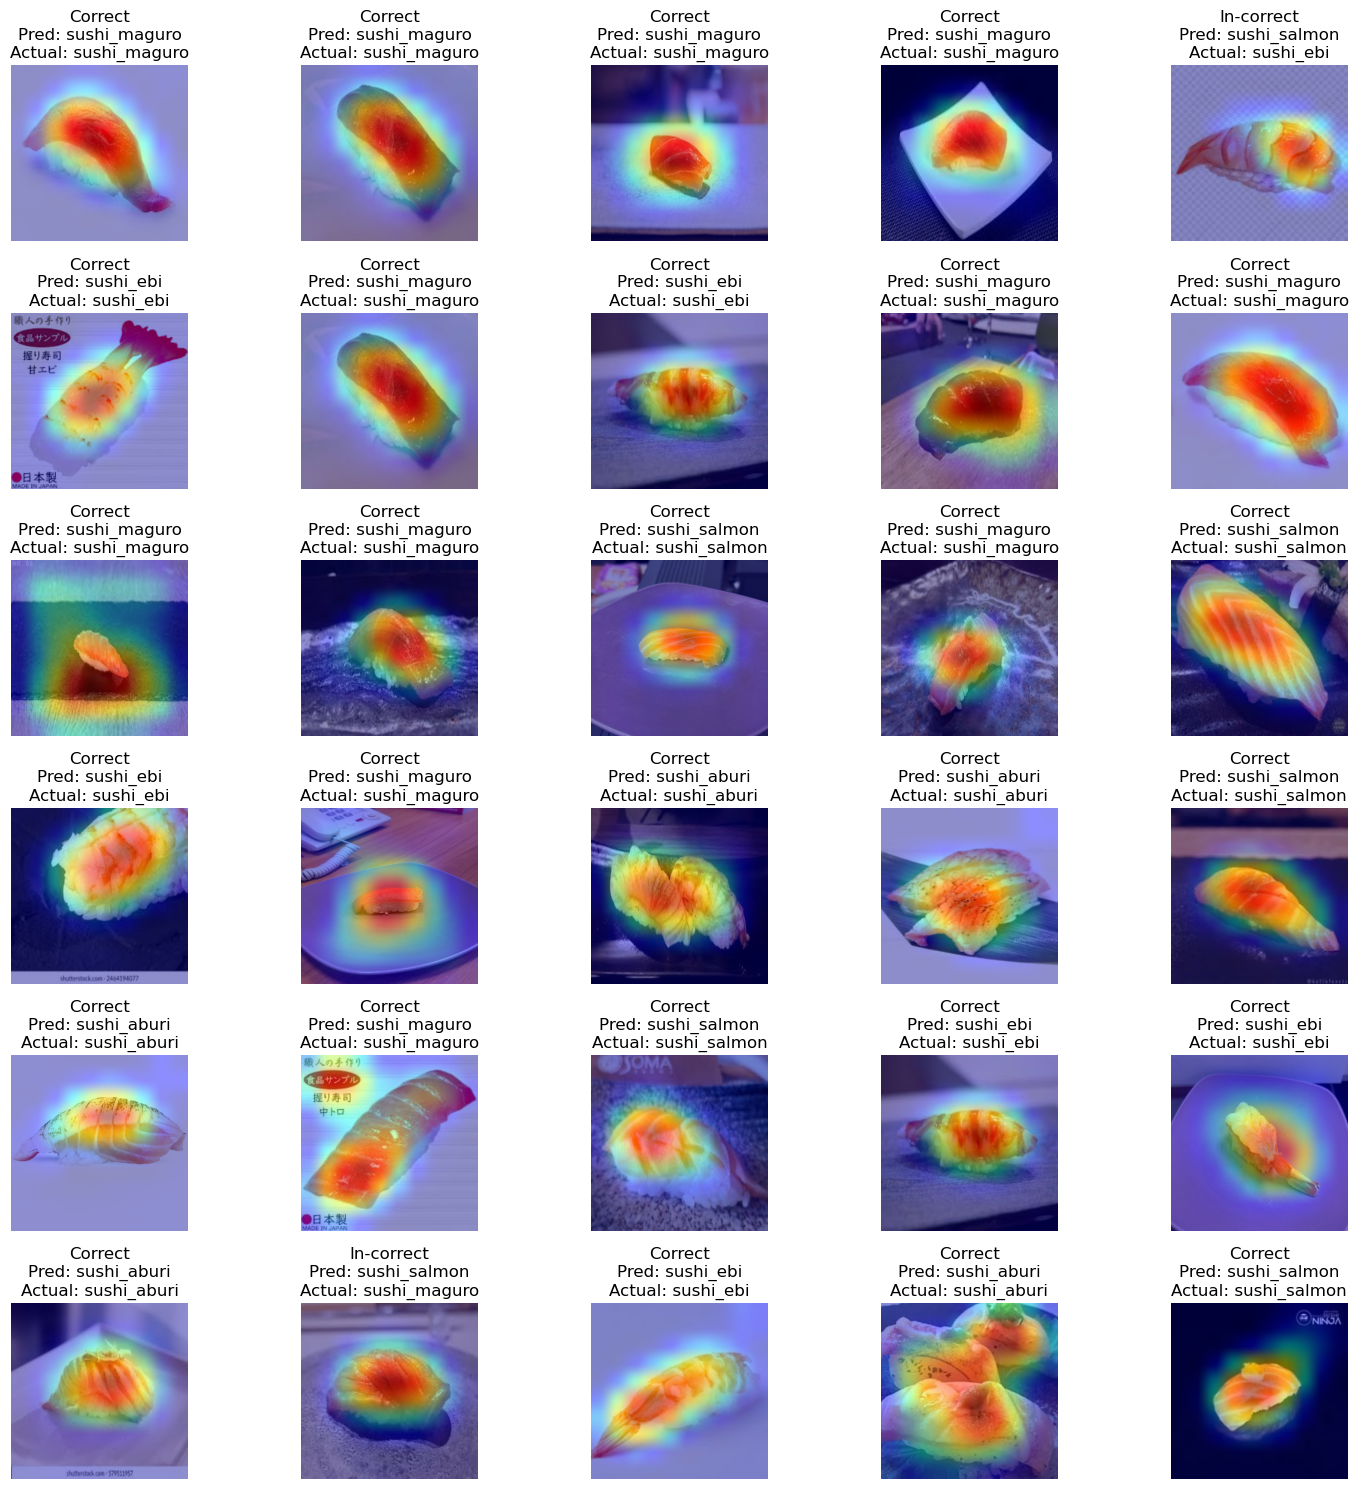

In [31]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def superimpose_gradcam_on_image(img, heatmap, alpha=0.8):
    # Rescale heatmap to a range of 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = plt.get_cmap("jet")

    # Get RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on the original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    
    return superimposed_img

def plot_gradcam_images(images, titles, cols=5, rows=3):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    axes = axes.flatten()
    for i, img in enumerate(images):
        axes[i].imshow(img)
        axes[i].set_title(titles[i])
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Collect images for plotting
gradcam_images = []
titles = []
total_img = 30
counter_correct = 0
counter_incorrect = 0

for i in range(total_img):
    c = np.random.randint(0, len(x_test) - 1)
    img_path = x_test[c]
    img_array = preprocess_input(img_path)
    
    # Disable softmax activation in the last layer
    model.layers[-1].activation = None

    # Get predictions
    preds = model.predict(img_array.reshape(img_shape))
    pred_label = label[np.argmax(preds)]
    true_label = label[y_test[c]]
    
    result = ''
    
    if pred_label == true_label:
        result = 'Correct'
        counter_correct += 1
    else:
        result = 'In-correct'
        counter_incorrect += 1

    # print(f"Predicted: {pred_label} | Actual: {true_label}")

    # Generate Grad-CAM heatmap
    heatmap = make_gradcam_heatmap(img_array.reshape(img_shape), model, last_conv_layer_name)

    # Superimpose heatmap on the image
    superimposed_img = superimpose_gradcam_on_image(img_path, heatmap)

    # Append to the list for plotting
    gradcam_images.append(superimposed_img)
    titles.append(f"{result}\nPred: {pred_label}\nActual: {true_label}")

print(f'correct : {counter_correct}, incorrect : {counter_incorrect}')

# Plot the images in a 5x6 grid
plot_gradcam_images(gradcam_images, titles, cols=5, rows=6)